In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve

from librosa.core import stft
from librosa.core import istft
from librosa import amplitude_to_db, db_to_amplitude
from librosa.display import specshow
from librosa.output import write_wav

from scipy.signal import butter, lfilter, csd

from utils import apply_reverb, read_wav
import corpus
import mir_eval

import pyroomacoustics as pra

(-1, 9)

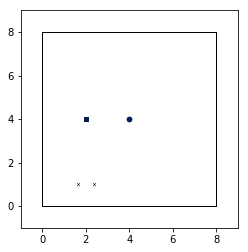

In [2]:
corners = np.array([[0,0], [0,8], [8,8], [8,0]]).T  # [x,y]
room = pra.Room.from_corners(corners)

s1, s2 = map(read_wav, corpus.experiment_files_timit())

if len(s1) > len(s2):
    pad_length = len(s1) - len(s2)
    s2 = np.pad(s2, (0,pad_length), 'reflect')
else:
    pad_length = len(s2) - len(s1)
    s1 = np.pad(s1, (0,pad_length), 'reflect')

room.add_source([4.,4.], signal=s1)
room.add_source([2.,4.], signal=s2)

R = pra.linear_2D_array(center=[2.,1.], M=2, phi=0, d=0.75)
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

fig, ax = room.plot()
ax.set_xlim([-1, 9])
ax.set_ylim([-1, 9])

3D case

(0, 6)

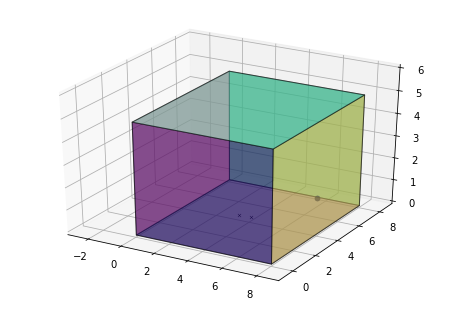

In [3]:
corners = np.array([[0,0], [0,8], [8,8], [8,0]]).T  # [x,y]
room = pra.Room.from_corners(corners)
room.extrude(5.)

s1, s2 = map(read_wav, corpus.experiment_files_timit())

if len(s1) > len(s2):
    pad_length = len(s1) - len(s2)
    s2 = np.pad(s2, (0,pad_length), 'reflect')
else:
    pad_length = len(s2) - len(s1)
    s1 = np.pad(s1, (0,pad_length), 'reflect')

room.add_source([8.,4.,1.6], signal=s1)
# room.add_source([2.,4.,1.6], signal=s2)
#[[X],[Y],[Z]]
R = np.asarray([[4.75,5.5],[2.,2.],[1.,1]])
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))
    
fig, ax = room.plot()
ax.set_xlim([-3, 9])
ax.set_ylim([-1, 9])
ax.set_zlim([0, 6])

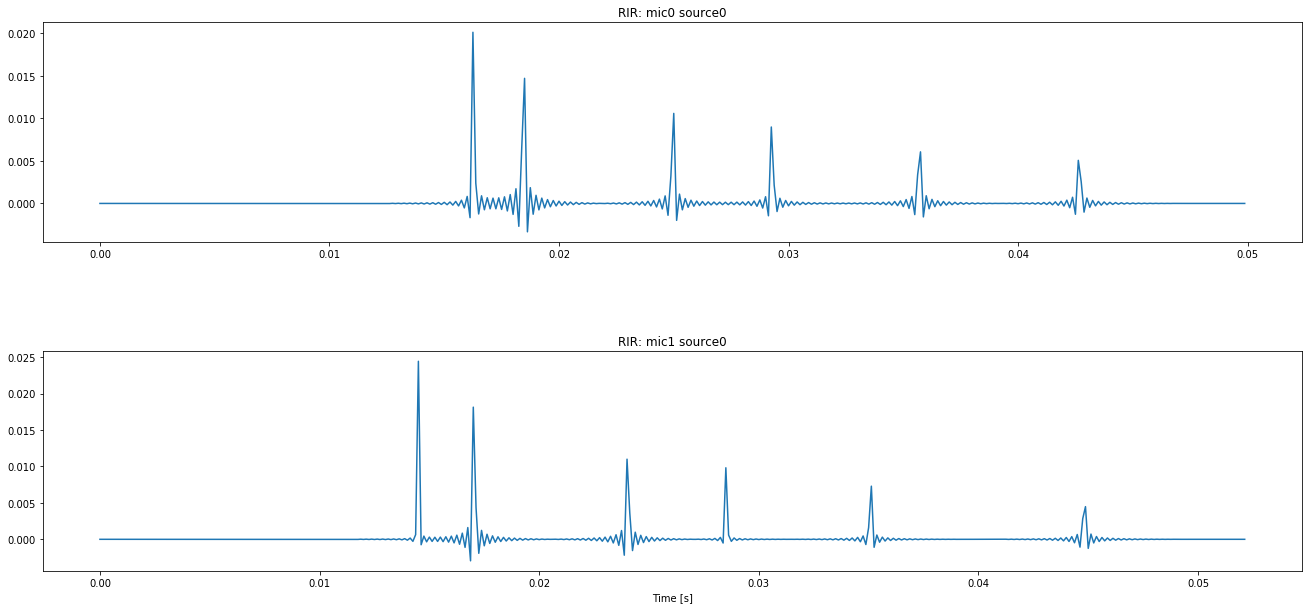

In [4]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)

In [5]:
room.simulate()
print(room.mic_array.signals.shape)

(2, 47214)


In [7]:
nfft=2048
win = 1024
hop = int(nfft/8)

X1 = stft(s1, n_fft=nfft, hop_length=hop, win_length=win)
Y1 = stft(room.mic_array.signals[0], n_fft=nfft, hop_length=hop, win_length=win)
Y2 = stft(room.mic_array.signals[1], n_fft=nfft, hop_length=hop, win_length=win)

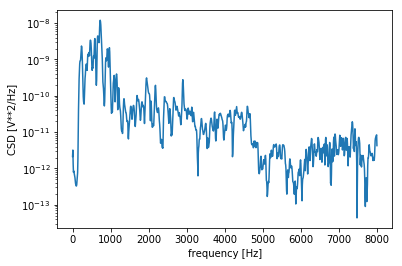

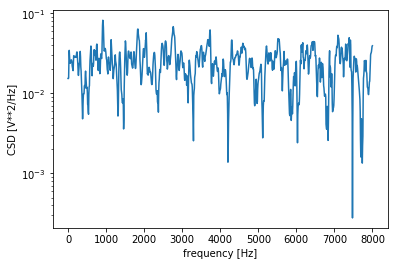

In [8]:

f, Pxy = csd(s1, room.mic_array.signals[0], 16000, nperseg=win, nfft=nfft, noverlap=hop)
_, Pxx = csd(s1, s1, 16000, nperseg=win, nfft=nfft, noverlap=hop)
plt.semilogy(f, np.abs(Pxy))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

H1 = np.divide(Pxy, Pxx)
plt.semilogy(f, np.abs(H1))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

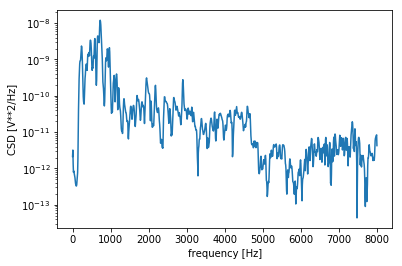

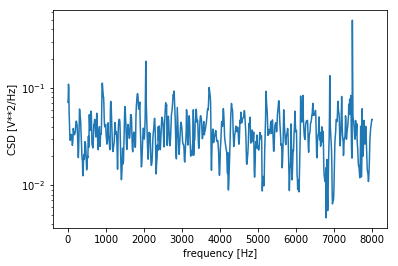

In [9]:
f, Pyx = csd(room.mic_array.signals[0], s1, 16000, nperseg=win, nfft=nfft, noverlap=hop)
_, Pyy = csd(room.mic_array.signals[0], room.mic_array.signals[0], 16000, nperseg=win, nfft=nfft, noverlap=hop)
plt.semilogy(f, np.abs(Pyx))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

H1 = np.divide(Pyy, Pyx)
plt.semilogy(f, np.abs(H1))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

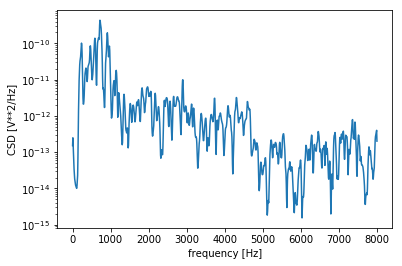

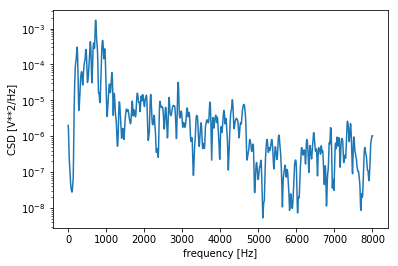

In [10]:
f, Pyy = csd(room.mic_array.signals[0], room.mic_array.signals[0], 16000, nperseg=win, nfft=nfft, noverlap=hop)
plt.semilogy(f, np.abs(Pyy))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

Pyy = np.conj(Y1)*Y1
plt.semilogy(f, np.abs(np.mean(Pyy,axis=1)))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

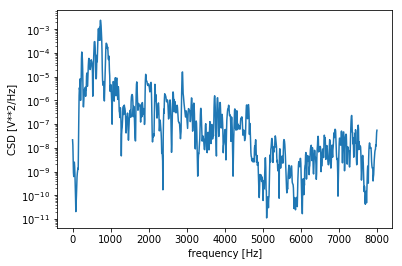

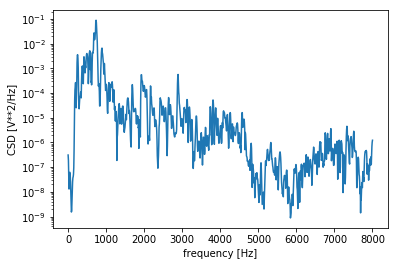

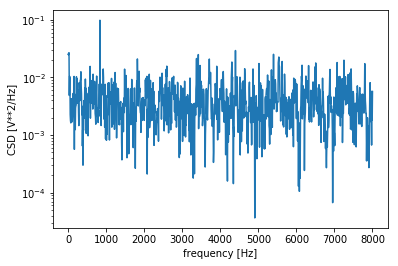

In [19]:
nfft=2048
win = 1024
hop = int(nfft/8)
Y1 = stft(room.mic_array.signals[0,:len(s1)], n_fft=nfft, hop_length=hop, win_length=win)
X1 = stft(s1, n_fft=nfft, hop_length=hop, win_length=win)

Gxx = X1 * np.conj(X1)
Gxyx = X1 * Y1 * np.conj(X1)
Gyxy = Y1 * X1 * np.conj(Y1)
Gxy = X1 *  np.conj(Y1)
Gyx = Y1 * np.conj(X1)
Gyy = Y1 * np.conj(Y1)


plt.semilogy(f, np.abs(np.mean(Gyxy,axis=1)))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

plt.semilogy(f, np.abs(np.mean(Gxyx,axis=1)))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

plt.semilogy(f, np.abs(np.mean(np.divide(Gyxy, np.sqrt(Gxx*Gyy*Gxx)),axis=1)))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

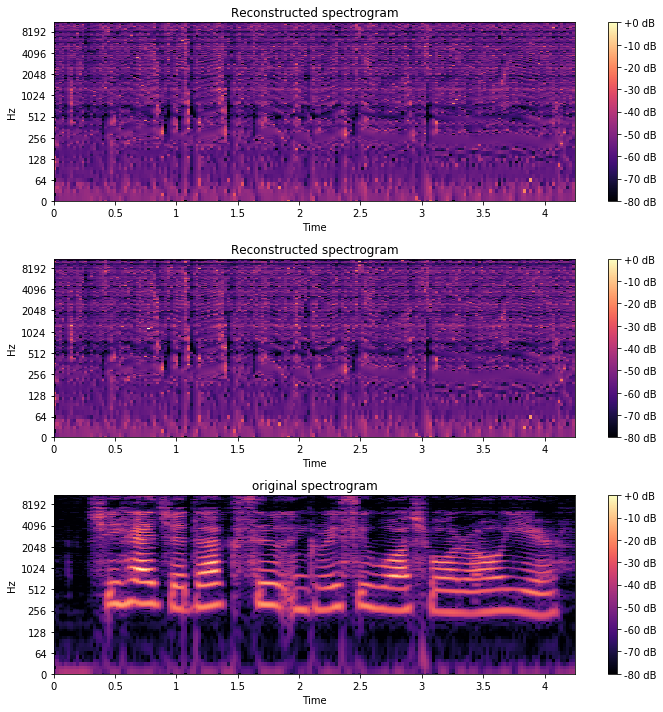

In [20]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(311)
specshow(amplitude_to_db(np.divide(Gxy, Gxx), ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
ax1 = plt.subplot(312)
specshow(amplitude_to_db(np.divide(Gyy, Gyx), ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.subplot(313, sharex=ax1)
specshow(amplitude_to_db(Y1, ref=np.max), y_axis='log', x_axis='time')
plt.title('original spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

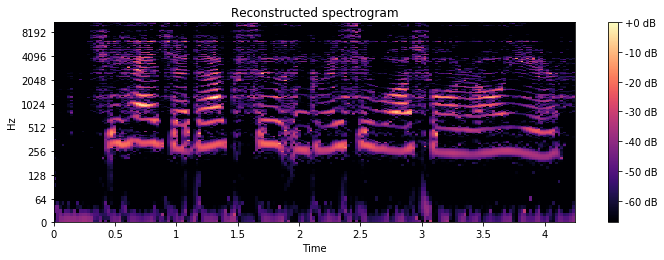

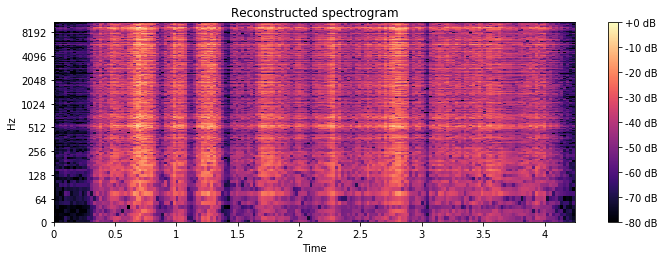

In [57]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(311)
specshow(amplitude_to_db(np.multiply(np.divide(Gxy, Gxx),Y1), ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plt.figure(figsize=(10,10))
ax1 = plt.subplot(311)
specshow(amplitude_to_db(np.multiply(np.linalg.pinv(np.divide(Gyy, Gyx)), Y1), ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()




0.08514404
42.764954


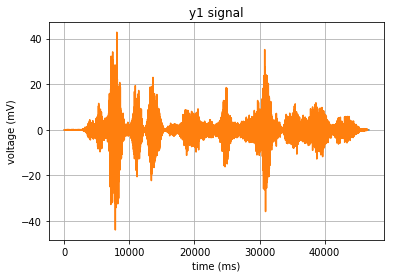

In [56]:
recon_y1_Hsgt1 = istft(np.multiply(np.divide(Gxy, Gxx),Y1), hop_length=hop, win_length=win) * 1000
recon_y1_Hsgt10 = istft(np.multiply(np.divide(Gyy, Gyx),Y1), hop_length=hop, win_length=win) * 1000

fig, ax = plt.subplots()
ax.plot(s1)
ax.plot(recon_y1_Hsgt10)
print(np.max(s1))
print(np.max(recon_y1_Hsgt10))

ax.set(xlabel='time (ms)', ylabel='voltage (mV)',
       title='y1 signal')
ax.grid()

write_wav('removed_reverb_xy.wav', recon_y1_Hsgt1, 16000)
write_wav('removed_reverb_yx.wav', recon_y1_Hsgt10, 16000)